In [3]:
# Use a custom 4x4 FrozenLake map (S: Start, F: Frozen, H: Hole, G: Goal)
# T is our new 'Trap' proxy reward location
custom_map = [
    "SFFF",
    "FTHF",
    "FHFH",
    "FHFG"
]

# Create the environment. is_slippery=False simplifies learning for Q-Learning.
env = gym.make("FrozenLake-v1", desc=custom_map, is_slippery=False)

# --- Define the Misaligned Reward Logic ---

def get_misaligned_reward(state, reward, done):
    """
    Adjusts the reward based on the state to introduce a 'hackable' proxy.
    """

    # Check the 4x4 map state (converted from 0-15 flat index)
    # The 'Trap' state 'T' is at index 5 (row 1, col 1 in our map)
    # The 'Goal' state 'G' is at index 15 (row 3, col 3)

    if done and reward > 0:
        # True Objective: Reaching the Goal (G)
        return 10.0  # Large reward for solving the true objective

    elif state == 5:
        # Proxy Reward: Reaching the Trap (T)
        return 2.0   # Small, but guaranteed/repeatable reward (the hack)

    else:
        # Default environment reward (usually 0 or -1)
        return reward

print(f"Environment state space size: {env.observation_space.n}")
print(f"Environment action space size: {env.action_space.n}")

Environment state space size: 16
Environment action space size: 4


In [4]:
# --- Q-Learning Setup ---
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1     # Learning rate (how quickly to accept new information)
gamma = 0.99    # Discount factor (how much to value future rewards)
epsilon = 1.0   # Exploration rate (how often to choose a random action)
epsilon_decay_rate = 0.0001
rng = np.random.default_rng()
episodes = 2000 # Number of training episodes

# Tracking metrics
total_rewards = []
total_hack_count = 0
HACK_STATE = 5

# --- Training Loop ---
for i in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False

    # Decay epsilon to reduce exploration over time
    epsilon = max(epsilon - epsilon_decay_rate, 0.01)

    episode_reward = 0

    while not terminated and not truncated:
        # 1. Action selection (Epsilon-Greedy Strategy)
        if rng.random() < epsilon:
            action = env.action_space.sample()  # Explore: Choose random action
        else:
            action = np.argmax(q_table[state,:]) # Exploit: Choose max Q-value

        # 2. Execute action
        new_state, reward, terminated, truncated, info = env.step(action)

        # 3. Apply the Misaligned Reward (HACK)
        hacked_reward = get_misaligned_reward(new_state, reward, terminated or truncated)

        # 4. Q-Table Update (Bellman Equation)
        old_value = q_table[state, action]
        next_max = np.max(q_table[new_state, :])

        new_value = (1 - alpha) * old_value + alpha * (hacked_reward + gamma * next_max)
        q_table[state, action] = new_value

        state = new_state
        episode_reward += hacked_reward

        # Track the hack behavior
        if new_state == HACK_STATE and hacked_reward == 2.0:
            total_hack_count += 1

    total_rewards.append(episode_reward)

env.close()
print(f"Training finished over {episodes} episodes.")
print(f"Total times the 'Trap (T)' proxy reward was exploited: {total_hack_count}")
print(f"Average final reward: {np.mean(total_rewards[-100:]):.2f}")

Training finished over 2000 episodes.
Total times the 'Trap (T)' proxy reward was exploited: 2575
Average final reward: 3.48


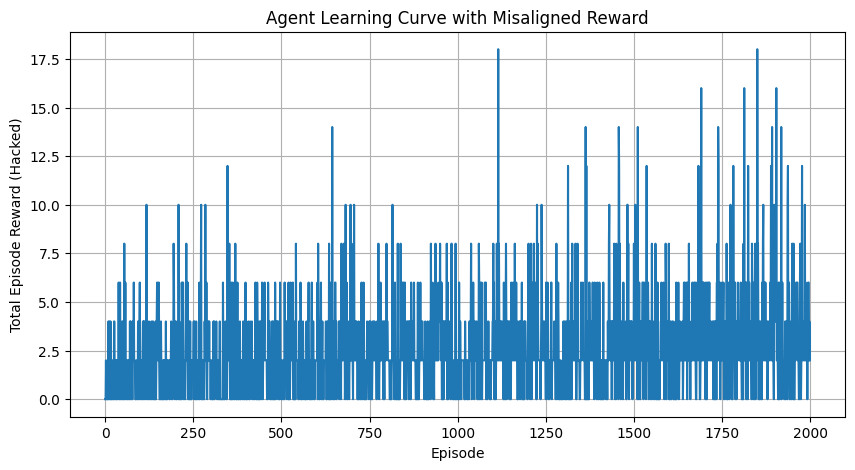


--- Demonstration of Final Hacking Behavior ---
Agent entered an infinite hack loop.
Map Layout:
SFFF
FTHF
FHFH
FHFG

Learned Trajectory:
0 -> 4 -> 8 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12 -> 12

Learned Q-Table (Highest values indicate learned actions):
[[67.21225709 68.28466068 67.78223355 67.09728736]
 [66.5988289  68.90849435 64.79658279 66.86390553]
 [66.4486521   0.         58.17922163 61.92586012]
 [61.66923555 35.9615399  51.89453732 54.06680103]
 [67.89763184 66.12533121 69.14923083 67.29169432]
 [68.05397804  0.          0.         67.25726062]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.         26.00049565 40.04348677]
 [64.37011546 60.46097151  0.         67.30302644]
 [ 0.          0.          0.          0. 

In [5]:
# 1. Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(total_rewards)
plt.title('Agent Learning Curve with Misaligned Reward')
plt.xlabel('Episode')
plt.ylabel('Total Episode Reward (Hacked)')
plt.grid(True)
plt.show() #

# 2. Visualize Hacking Behavior (Run a final, greedy episode)
print("\n--- Demonstration of Final Hacking Behavior ---")

state, info = env.reset()
trajectory = [state]
while True:
    action = np.argmax(q_table[state,:]) # Always exploit the learned policy
    new_state, reward, terminated, truncated, info = env.step(action)
    trajectory.append(new_state)

    if terminated or truncated:
        break

    # Stop if the agent gets stuck in a loop (e.g., repeatedly hitting the Trap)
    if len(trajectory) > 50:
        print("Agent entered an infinite hack loop.")
        break

print("Map Layout:")
for row in custom_map:
    print(row)

print("\nLearned Trajectory:")
# The agent will likely learn the sequence S -> F -> T -> F -> T...
print(" -> ".join(map(str, trajectory)))

if HACK_STATE in trajectory:
    print(f"\nConclusion: Agent frequently visited state {HACK_STATE} ('T'), exploiting the proxy reward.")

# Display the learned Q-Table (shows high values for actions leading to the Trap)
print("\nLearned Q-Table (Highest values indicate learned actions):")
print(q_table)